# Aging Aware with Model Variation
Previously, we optimize the following functional:
$$ \min_\theta \, \int_{t=0}^{1} \; L(\theta(t)) \, {\rm d}t. $$
The optimum is for a specific aging model $\omega$, i.e., we minimized the 
$$ \min_\theta \, \int_{t=0}^{1} \; L(\theta(t,\omega)) \, {\rm d}t. $$
However, we dont know how will the resistance decay, i.e., we should also minimize the loss function w.r.t. aging models with different parameters. That means we need to optimized
$$ \min_\theta \, \int_{\omega}\int_{t=0}^{1} \; L(\theta(t,\omega)) \, {\rm d}t\, p(\omega){\rm d}\omega. $$
The Mento Carlo Approximation is then
$$
\min_{\theta_{\rm init}} \frac{1}{\Omega}\frac{1}{K}\sum_{\omega\in\mathfrak{M}}\sum_{k\in \mathfrak{K} } L \left(\theta[k, \omega]\right),
$$
where $\mathfrak{M}$ is the set of $\Omega$ elements following the distribution $p(\omega)$. $p(\omega)$ is the distributions of parameters of the aging model. We have already obtained these distributions as we modeled the aging decay.

That means we should optimize this problem by
$$
\begin{align}
\theta_{\rm init}&:=\theta_{\rm init} - \alpha\cdot\nabla_{\theta_{\rm init}}\left(\frac{1}{\Omega}\frac{1}{K}\sum_{\omega\in\mathfrak{M}}\sum_{k\in \mathfrak{K} } L \left(\theta[k, \omega]\right)\right)\\
&=\theta_{\rm init} - \frac{\alpha}{\Omega K}\cdot\nabla_{\theta_{\rm init}}\left(\sum_{\omega\in\mathfrak{M}}\sum_{k\in \mathfrak{K} } L \left(\theta[k, \omega]\right)\right)\\
&=\theta_{\rm init} - \frac{\alpha}{\Omega K}\left(\sum_{\omega\in\mathfrak{M}}\sum_{k\in \mathfrak{K} }\nabla_{\theta_{\rm init}} L \left(\theta[k, \omega]\right)\right)
\end{align}
$$

# Import library

In [1]:
import importlib
from torch.autograd import Variable
import torch
import pickle
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import pNN_aging_aware_vectorization as pnnv
import training_vectorization as tv
import random
import config
sys.path.append(os.path.join(os.getcwd(), 'Aging_Model'))

# Random Seed

In [2]:
seed = 0

random.seed(seed);
np.random.seed(seed);
torch.manual_seed(seed);

# Get Aging Model

In [3]:
with open(os.path.join(os.getcwd(), 'Aging_Model', 'exp_aging_model.p'), 'rb') as f:
    age_generator = pickle.load(f)

# Device

In [4]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cuda:0')
device = 'cpu'
device

'cpu'

# Prepare data

## Dataset

In [5]:
if config.current_dataset is not None:
    ds = config.datasets[config.current_dataset]
else:
    ds = config.datasets[0]

ds

'Cardio'

## Load data

In [6]:
datapath = os.path.join(os.getcwd(), 'Datasets',
                        'dataset_processed', f'Dataset_{ds}.p')
with open(datapath, 'rb') as f:
    dataset = pickle.load(f)
X = dataset['X'].float()
y = dataset['y']

E, N_features, N_class = X.shape[0], X.shape[1], torch.max(
    torch.unique(y)).item()+1
X.shape, y.shape, E, N_features, N_class

(torch.Size([2124, 21]), torch.Size([2124]), 2124, 21, 3)

## Pseudo-electrical Signal

In [7]:
X = X - torch.min(X, axis=0)[0]
X = X / (torch.max(X, axis=0)[0])
torch.min(X), torch.max(X)

(tensor(0.), tensor(1.))

In [8]:
X[:10, :9]

tensor([[0.4815, 0.3158, 0.0000, 0.4000, 0.2000, 0.0000, 0.0000, 0.0667, 0.2794],
        [0.5000, 0.1579, 0.0000, 0.5333, 0.2000, 0.0000, 0.0000, 0.0533, 0.2794],
        [0.5185, 0.1579, 0.0000, 0.5333, 0.2000, 0.0000, 0.0000, 0.0533, 0.3235],
        [0.4815, 0.3684, 0.0000, 0.5333, 0.0000, 0.0000, 0.0000, 0.0533, 0.3235],
        [0.5185, 0.0526, 0.0000, 0.6667, 0.6000, 0.0000, 0.4000, 0.1867, 0.8382],
        [0.5185, 0.0526, 0.0000, 0.8667, 0.5333, 0.0000, 0.6000, 0.2267, 0.8971],
        [0.2963, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.9467, 0.0441],
        [0.2963, 0.0000, 0.0000, 0.1333, 0.0000, 0.0000, 0.0000, 0.9600, 0.0441],
        [0.2963, 0.0000, 0.0000, 0.2000, 0.0000, 0.0000, 0.0000, 0.9867, 0.0147],
        [0.8333, 0.0000, 0.0000, 0.0667, 0.0667, 0.0000, 0.0000, 0.6933, 0.2500]])

In [9]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split

# generate tensordataset
dataset = TensorDataset(X.to(device), y.to(device))

# split
train_rate = 0.6
test_rate = 0.2
valid_rate = 0.2
E_train = min(8192, int(E*train_rate))
E_test = min(2048, int(E*test_rate))
E_valid = min(2048, int(E*valid_rate))

train_data, rest_data = random_split(dataset, [E_train, E-E_train])
test_data, rest_data = random_split(rest_data, [E_test, E-E_train-E_test])
valid_data, rest_data = random_split(rest_data, [E_valid, E-E_train-E_test-E_valid])

len(train_data), len(test_data), len(valid_data)

(1274, 424, 424)

In [10]:
# batch
train_loader = DataLoader(train_data, batch_size=len(train_data))
test_loader = DataLoader(test_data, batch_size=len(test_data))
valid_loader = DataLoader(valid_data, batch_size=len(valid_data))

# Hyperparameter

In [11]:
N_Hidden = 3
m = 0.3
T = 0.1
M_train = 50
K_train = 10
M_test = 20
K_test = 10

# Normal PNN

## Define

In [12]:
PNN = torch.nn.Sequential(pnnv.PNNLayer(N_features, N_Hidden, age_generator, xpu=device),
                         pnnv.PNNLayer(N_Hidden, N_class, age_generator, xpu=device))

PNN.apply(lambda z: pnnv.MakeModel(z, M=1))
PNN.apply(lambda z: pnnv.SetTime(z, t=[0]))

PNN.to(device)

Sequential(
  (0): PNNLayer()
  (1): PNNLayer()
)

## Training

In [13]:
optimizer_PNN = torch.optim.Adam(PNN.parameters(), lr=0.001)
train_loader = DataLoader(train_data, batch_size=len(train_data))
train_loss_PNN, test_loss_PNN, parameter_PNN = tv.train_normal_pnn(PNN, train_loader, test_loader,
                                                                   m, T, optimizer_PNN,
                                                                   pnnv.LossFunction, Epoch=50000, cache=ds)

  0%|          | 0/50000 [00:00<?, ?it/s]

| Epoch:     0 | Accuracy: 0.77123 | Loss: 0.945916593 |
| Epoch:   500 | Accuracy: 0.82075 | Loss: 0.246891484 |
| Epoch:  1000 | Accuracy: 0.87028 | Loss: 0.212601736 |
| Epoch:  1500 | Accuracy: 0.86557 | Loss: 0.204478264 |
| Epoch:  2000 | Accuracy: 0.86321 | Loss: 0.202298865 |
| Epoch:  2500 | Accuracy: 0.85849 | Loss: 0.204633966 |
| Epoch:  3000 | Accuracy: 0.86085 | Loss: 0.205465496 |
| Epoch:  3500 | Accuracy: 0.86085 | Loss: 0.207574606 |
| Epoch:  4000 | Accuracy: 0.86321 | Loss: 0.207464501 |
| Epoch:  4500 | Accuracy: 0.86321 | Loss: 0.207349807 |
| Epoch:  5000 | Accuracy: 0.86321 | Loss: 0.207826808 |
| Epoch:  5500 | Accuracy: 0.86085 | Loss: 0.208151013 |
| Epoch:  6000 | Accuracy: 0.86085 | Loss: 0.208101600 |
| Epoch:  6500 | Accuracy: 0.86085 | Loss: 0.208245277 |
| Epoch:  7000 | Accuracy: 0.86085 | Loss: 0.208273292 |
| Epoch:  7500 | Accuracy: 0.86085 | Loss: 0.208999187 |
| Epoch:  8000 | Accuracy: 0.86085 | Loss: 0.209549919 |
| Epoch:  8500 | Accuracy: 0.86

(1988, 0.20181649923324585)

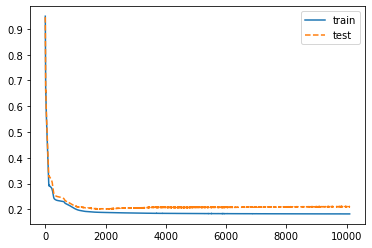

In [14]:
plt.plot(train_loss_PNN, '-', label='train')
plt.plot(test_loss_PNN, '--', label='test')
plt.legend()
best = np.argmin(test_loss_PNN)
PNN.load_state_dict(parameter_PNN)
best, test_loss_PNN[best]

## Save Model

In [15]:
with open(f'./result/{ds}_PNN_{seed}.p', 'wb') as f:
    pickle.dump(PNN, f)

In [16]:
PNN.to('cpu')

Sequential(
  (0): PNNLayer()
  (1): PNNLayer()
)